In [1]:
%pip install earthengine-api geemap --quiet

Note: you may need to restart the kernel to use updated packages.


In [21]:
%pip install geedim --quiet

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2024.6.1 requires fsspec==2024.6.1.*, but you have fsspec 2026.2.0 which is incompatible.


In [15]:
import ee
import geemap
import matplotlib.pyplot as plt

In [16]:
ee.Authenticate()
ee.Initialize(project = "")

In [17]:
REGION = ee.Geometry.Rectangle([
    74.1, 31.3,
    74.5, 31.7
])

YEARS = [2023, 2024, 2025]

VIZ_MIN = 1800
VIZ_MAX = 1950

In [18]:
CH4_COLLECTION = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_CH4')

In [19]:
def january_image(year, region):

    start = ee.Date.fromYMD(year, 1, 1)
    end   = ee.Date.fromYMD(year, 1, 31)

    img = (
        CH4_COLLECTION
        .filterDate(start, end)
        .filterBounds(region)
        .map(lambda i: i.select(
            'CH4_column_volume_mixing_ratio_dry_air_bias_corrected'
        ).updateMask(
            i.select('CH4_column_volume_mixing_ratio_dry_air_uncertainty').lt(50)
            .And(i.select('solar_zenith_angle').lt(70))
        ))
        .mean()
        .clip(region)
    )

    return img


In [8]:
Map = geemap.Map(center=[32.5, -102.5], zoom=6)

for year in YEARS:
    img = january_image(year, REGION)
    Map.addLayer(
        img,
        {
            'min': VIZ_MIN,
            'max': VIZ_MAX,
            'palette': [
                '0d0887','6a00a8','b12a90',
                'e16462','fca636','f0f921'
            ]
        },
        f'January {year} Mean CH₄'
    )

Map


Map(center=[32.5, -102.5], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

In [9]:
def january_mean_value(year, region):

    img = january_image(year, region)

    mean = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=7000,
        maxPixels=1e13
    )

    return mean.get(
        'CH4_column_volume_mixing_ratio_dry_air_bias_corrected'
    )


In [22]:
# Export methane images for each year
import os
os.makedirs('data', exist_ok=True)

for year in YEARS:
    img = january_image(year, REGION)
    filename = f'data/methane_lahore_{year}.tif'
    print(f'Exporting {filename}...')
    geemap.download_ee_image(img, filename, scale=1000, region=REGION, crs='EPSG:4326')
    print(f'Exported {filename}')

Exporting data/methane_lahore_2023.tif...


  0%|          |0/1 tiles [00:00<?]

Exported data/methane_lahore_2023.tif
Exporting data/methane_lahore_2024.tif...


  0%|          |0/1 tiles [00:00<?]

Exported data/methane_lahore_2024.tif
Exporting data/methane_lahore_2025.tif...


  0%|          |0/1 tiles [00:00<?]

Exported data/methane_lahore_2025.tif


Daily methane data saved to data/lahore_methane_timeseries.csv


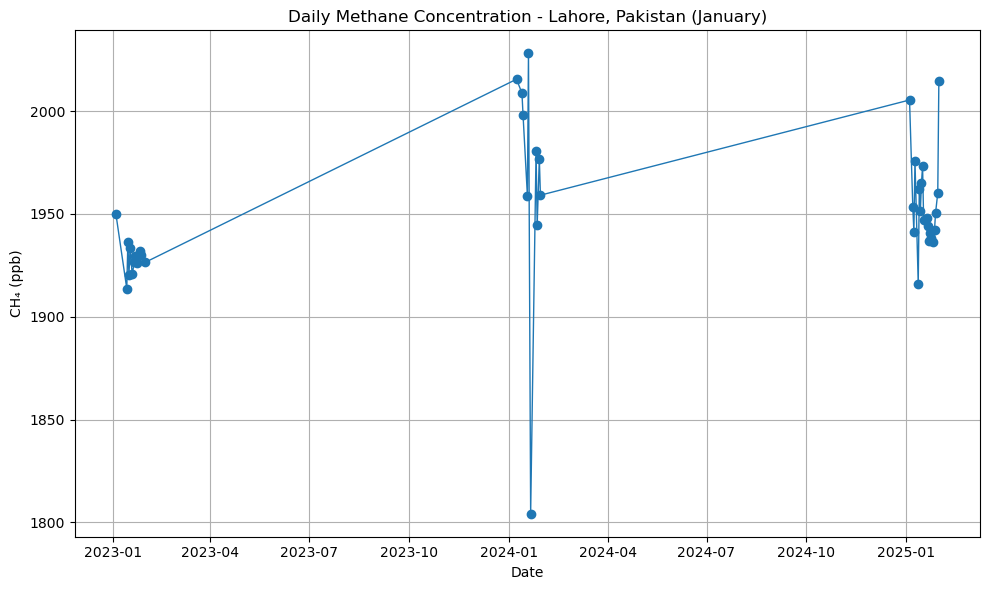

In [23]:
import pandas as pd
import os
os.makedirs('data', exist_ok=True)

dates = []
values = []

for year in YEARS:
    for day in range(1, 32):  # January 1 to 31
        start = ee.Date.fromYMD(year, 1, day)
        end = start.advance(1, 'day')
        
        img = (
            CH4_COLLECTION
            .filterDate(start, end)
            .filterBounds(REGION)
            .map(lambda i: i.select(
                'CH4_column_volume_mixing_ratio_dry_air_bias_corrected'
            ).updateMask(
                i.select('CH4_column_volume_mixing_ratio_dry_air_uncertainty').lt(50)
                .And(i.select('solar_zenith_angle').lt(70))
            ))
            .mean()
            .clip(REGION)
        )
        
        mean = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=REGION,
            scale=7000,
            maxPixels=1e13
        ).get('CH4_column_volume_mixing_ratio_dry_air_bias_corrected').getInfo()
        
        if mean is not None:
            dates.append(f'{year}-01-{day:02d}')
            values.append(mean)

df = pd.DataFrame({'date': dates, 'methane_ppb': values})
df.to_csv('data/lahore_methane_timeseries.csv', index=False)
print("Daily methane data saved to data/lahore_methane_timeseries.csv")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(df['date']), df['methane_ppb'], marker='o', linewidth=1)
plt.xlabel('Date')
plt.ylabel('CH₄ (ppb)')
plt.title('Daily Methane Concentration - Lahore, Pakistan (January)')
plt.grid(True)
plt.tight_layout()
plt.show()